<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Supervised_Regression_First_Run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align:center;"><b> Supervised Regression - Meteorological
data from the Hawaii HI-SEAS weather station </b></h1>

#### Author: Jeff Greene
#### Date : 1/26/2025


The data set I am using for this module consists of meteorological data from the Hawaii HI-SEAS weather station for four months (September through December 2016) between Mission IV and Mission V that I found on Kaggle. According to their website:


> The Hawai‘i Space Exploration Analog and Simulation (HI-SEAS) is a Mars and Moon exploration analog research station, currently operated by the International MoonBase Alliance.
Located approximately 8,200 feet above sea level, the HI-SEAS habitat is a 1,200 square foot dome located on a Mars-like site on the Mauna Loa volcano on Hawai‘i Island. HI-SEAS has been the home to five successful long-duration (4 to 12 month) NASA Mars simulation missions and tens of other analog space missions in collaboration with multiple space agencies, companies, and organizations worldwide.




In [1]:
import os
import requests
from io import StringIO

# For preprocessing labels and splitting the data
# XGBoost and SciKit learn had a strange interaction, so I needed to add this code. This is described on
# Stack Overflow "Scikit-learn version 1.6 modified the API around its "tags", and that's the cause of this error.""
# https://stackoverflow.com/questions/79290968/super-object-has-no-attribute-sklearn-tags
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

from sklearn import preprocessing
# To standardize the features
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV,RepeatedKFold, cross_val_score
import scipy.stats as stats
from scipy.stats import pearsonr, boxcox, yeojohnson

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

#Support Vector Regressor
from sklearn.svm import SVR
# Linear Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
# XGBoost
from xgboost import XGBRegressor

import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
!pip install plotly
import plotly.graph_objects as go # Import the plotly.graph_objects module

# Set the figure size
plt.rcParams["figure.figsize"] = (12,12)
# Set the default font size
plt.rcParams.update({'font.size': 12})

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


## Load the data

---


This step includes loading the data from the CSV. I have added included steps to validate the GitHub URL and data integrity, which I applied in a previous notebook to ensure my data is pulled in correctly.

In [2]:
def validate_file_path_github(file_url):
    """
    Validates if a file path from GitHub URL exists.
    """
    try:
        response = requests.head(file_url)
        if response.status_code == 200:
            print(f"File path '{file_url}' exists.")
            return True
        else:
             print(f"File path '{file_url}' does not exist. Status code: {response.status_code}")
             return False
    except requests.ConnectionError as e:
        print(f"Error connecting to {file_url}: {e}")
        return False
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return False

def validate_data_integrity_github(file_url, expected_columns, expected_data_types={}):
    """
    Validates data integrity after loading from a GitHub URL.
    """
    try:
        response = requests.get(file_url)
        response.raise_for_status()
        csv_content = StringIO(response.text)
        df = pd.read_csv(csv_content)
    except requests.exceptions.RequestException as e:
         print(f"Failed to fetch data from {file_url}: {e}")
         return False
    except pd.errors.ParserError as e:
        print(f"Failed to parse CSV content: {e}")
        return False

    # Check for expected columns
    if not all(col in df.columns for col in expected_columns):
        print(f"Data does not contain all expected columns. Expected: {expected_columns}, Found: {list(df.columns)}")
        return False

     # Check for data types
    for column, expected_type in expected_data_types.items():
        if column in df.columns:
            if df[column].dtype != expected_type:
                 print(f"Column '{column}' has type {df[column].dtype}, but expected {expected_type}")
                 return False

    print("Data integrity check passed.")
    return True

In [3]:
file_url = 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/SolarPrediction.csv'
expected_columns = ['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise', 'TimeSunSet']
expected_data_types = {'UNIXTime':'int64', 'Data':'object', 'Time':'object', 'Radiation':'float64', 'Temperature':'int64', 'Pressure':'float64', 'Humidity':'int64', 'WindDirection(Degrees)':'float64', 'Speed':'float64', 'TimeSunRise':'object', 'TimeSunSet':'object'}
if validate_file_path_github(file_url):
    if validate_data_integrity_github(file_url, expected_columns, expected_data_types):
      # Proceed with loading data
      df = pd.read_csv(file_url, index_col=None, header=0)
      print("Data has been validated and loaded.")
    else:
      print("Data integrity check failed.")
else:
    # Handle file not found error
    print(f"GitHub file: {file_url} does not exist")

File path 'https://raw.githubusercontent.com/jeffbgreene/geology-558/main/SolarPrediction.csv' exists.
Data integrity check passed.
Data has been validated and loaded.


## Exploratory Data Analysis


---
The original data consists of assorted time and numerical features. Numeric values represent various meteorological attributes. I included the complete EDA done in the previous notebook for refernce, which included engineering a feature for EDA related to the UNIX time as a time stamp. I will not use this feature for training however

The goal of this notebook is to use the eather elements as inputs to build models that can accurately predict the radiation as a numeric value. I had good results with XGBoost for the previous assignment, so I planned on using it again for this assignment.

**The features utilized for training are: Temperature, Pressure, Humidity, WindDirection, and speed.**


In [4]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [5]:
# Derive a new column called datetime
df['UNIXDateTime'] = pd.to_datetime(df['UNIXTime'], unit='s')

In [6]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,UNIXDateTime
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,2016-09-30 09:55:26
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,2016-09-30 09:50:23
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,2016-09-30 09:45:26
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,2016-09-30 09:40:21
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,2016-09-30 09:35:24


In [7]:
print(f"The length of the data set is {len(df)} rows")

The length of the data set is 32686 rows


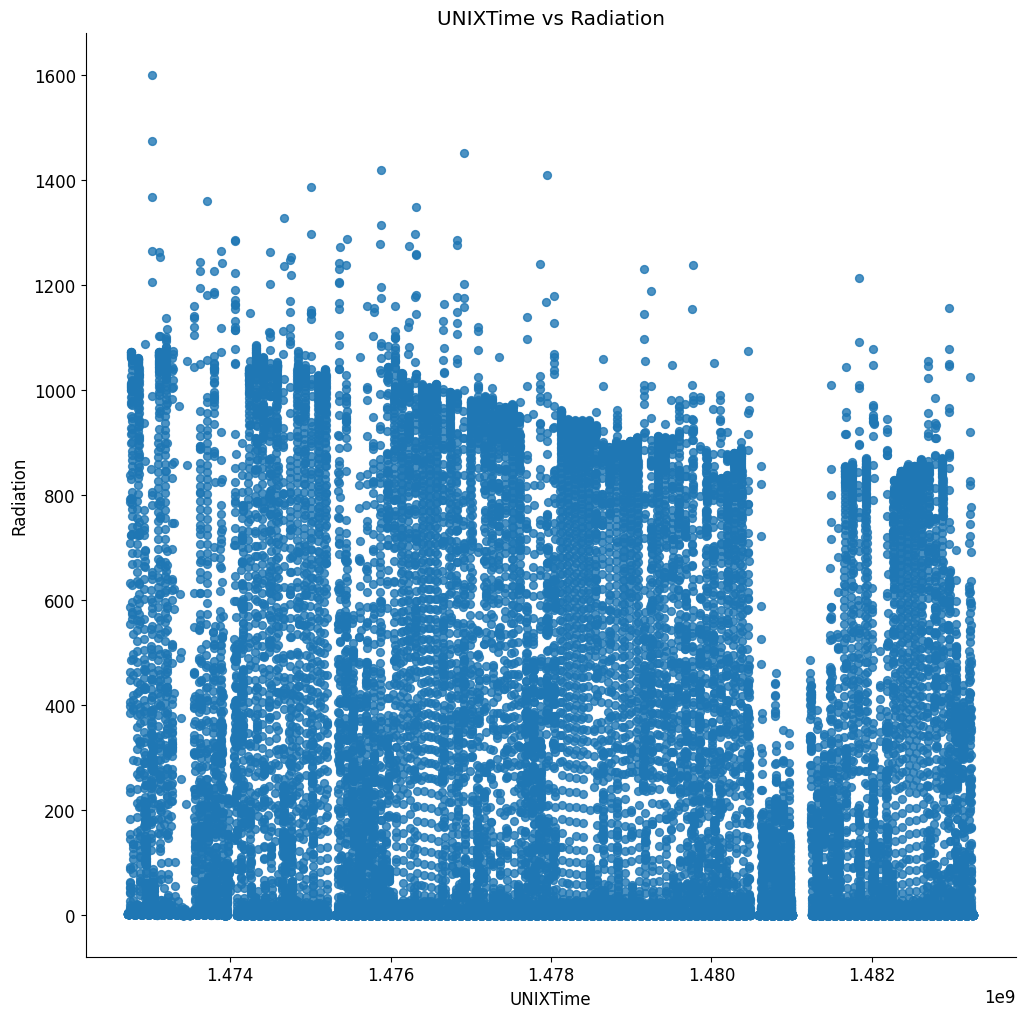

In [8]:
# @title UNIXTime vs Radiation

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='UNIXTime', y='Radiation', s=32, alpha=.8)
plt.title('UNIXTime vs Radiation')
plt.gca().spines[['top', 'right',]].set_visible(False)

### <p style="text-align:center;"><i>Figure 1: The time as a UNIX timestamp (number of seconds since January 1, 1970) vs radiation.</i></p>

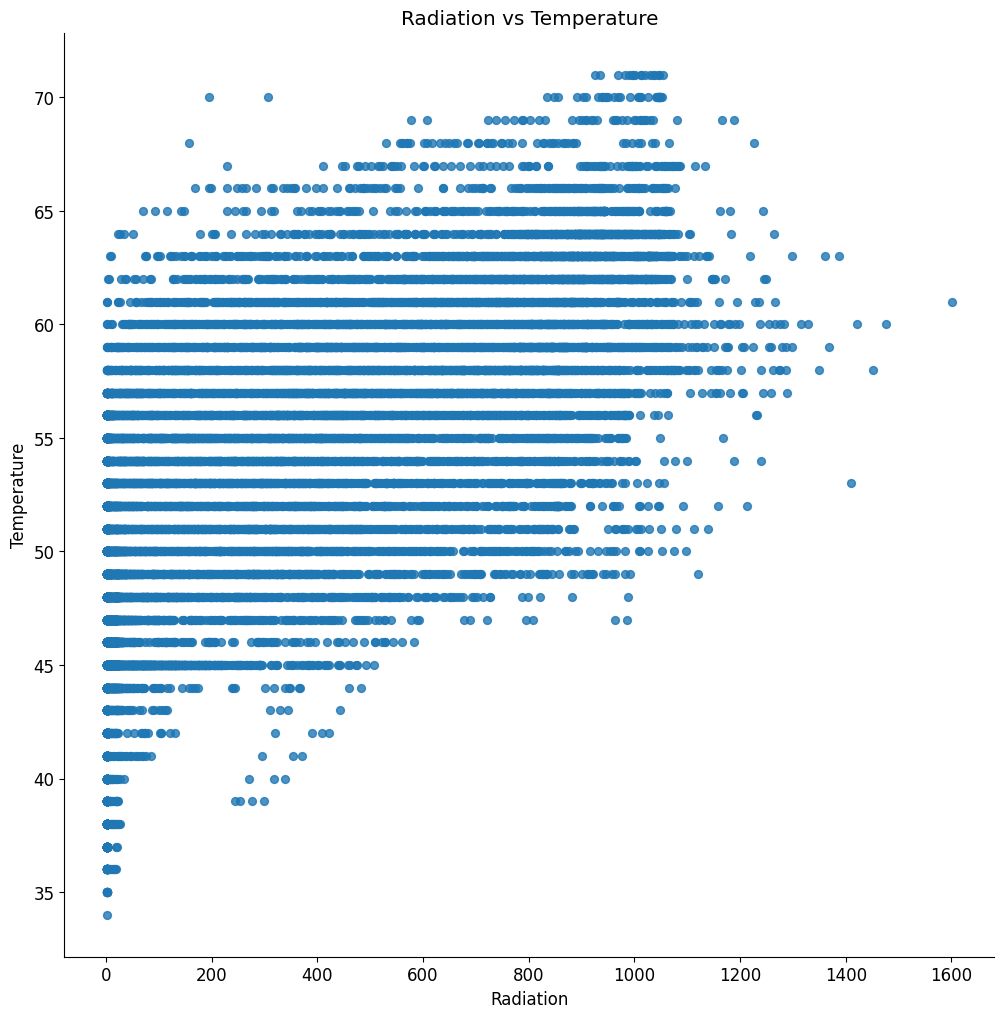

In [9]:
# @title Radiation vs Temperature

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Radiation', y='Temperature', s=32, alpha=.8)
plt.title('Radiation vs Temperature')
plt.gca().spines[['top', 'right',]].set_visible(False)

### <p style="text-align:center;"><i>Figure 2: Radiation vs temperature .</i></p>

In [10]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,UNIXDateTime
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,2016-11-02 00:41:04.944808192
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,2016-09-01 10:00:08
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,2016-10-04 02:01:37.500000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,2016-11-01 18:47:49.500000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,2016-11-30 04:28:48
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,2017-01-01 09:55:01
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,NaN


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   UNIXTime                32686 non-null  int64         
 1   Data                    32686 non-null  object        
 2   Time                    32686 non-null  object        
 3   Radiation               32686 non-null  float64       
 4   Temperature             32686 non-null  int64         
 5   Pressure                32686 non-null  float64       
 6   Humidity                32686 non-null  int64         
 7   WindDirection(Degrees)  32686 non-null  float64       
 8   Speed                   32686 non-null  float64       
 9   TimeSunRise             32686 non-null  object        
 10  TimeSunSet              32686 non-null  object        
 11  UNIXDateTime            32686 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3), ob

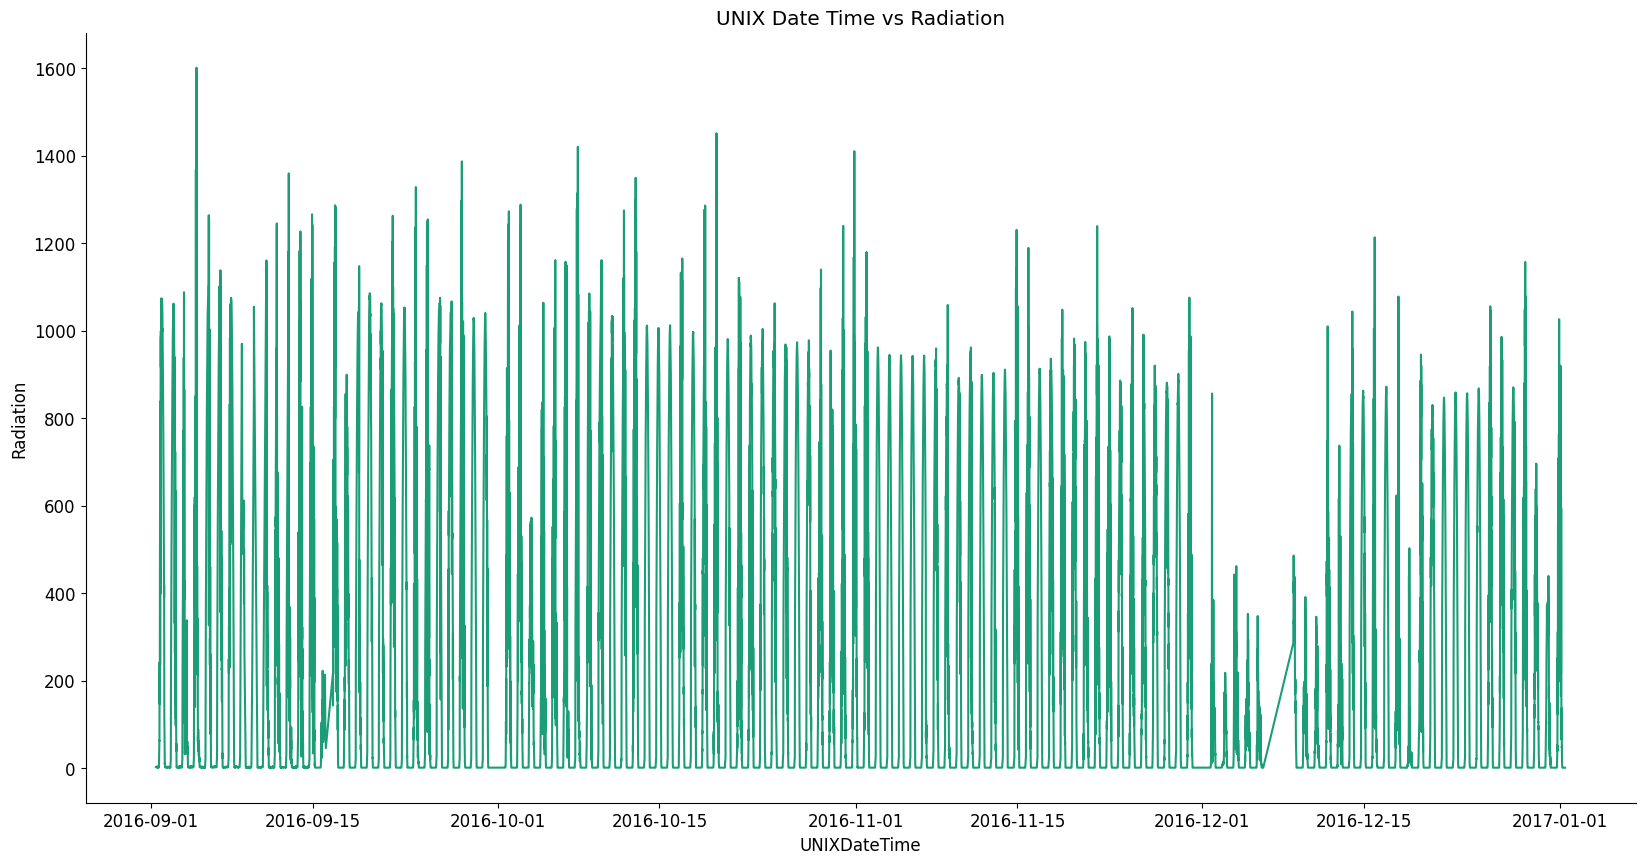

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UNIXDateTime']
  ys = series['Radiation']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(20,10))
df_sorted = df.sort_values('UNIXDateTime', ascending=True)
plt.title('UNIX Date Time vs Radiation')
_plot_series(df_sorted, '')

sns.despine(fig=fig, ax=ax)
plt.xlabel('UNIXDateTime')
_ = plt.ylabel('Radiation')

### <p style="text-align:center;"><i>Figure 3: I converted the timestamps to dates to visualize time vs radiation. The spikes seem to diminish as the end of summer changes to fall and then winter. I may need to account for this when splitting my data.</i></p>

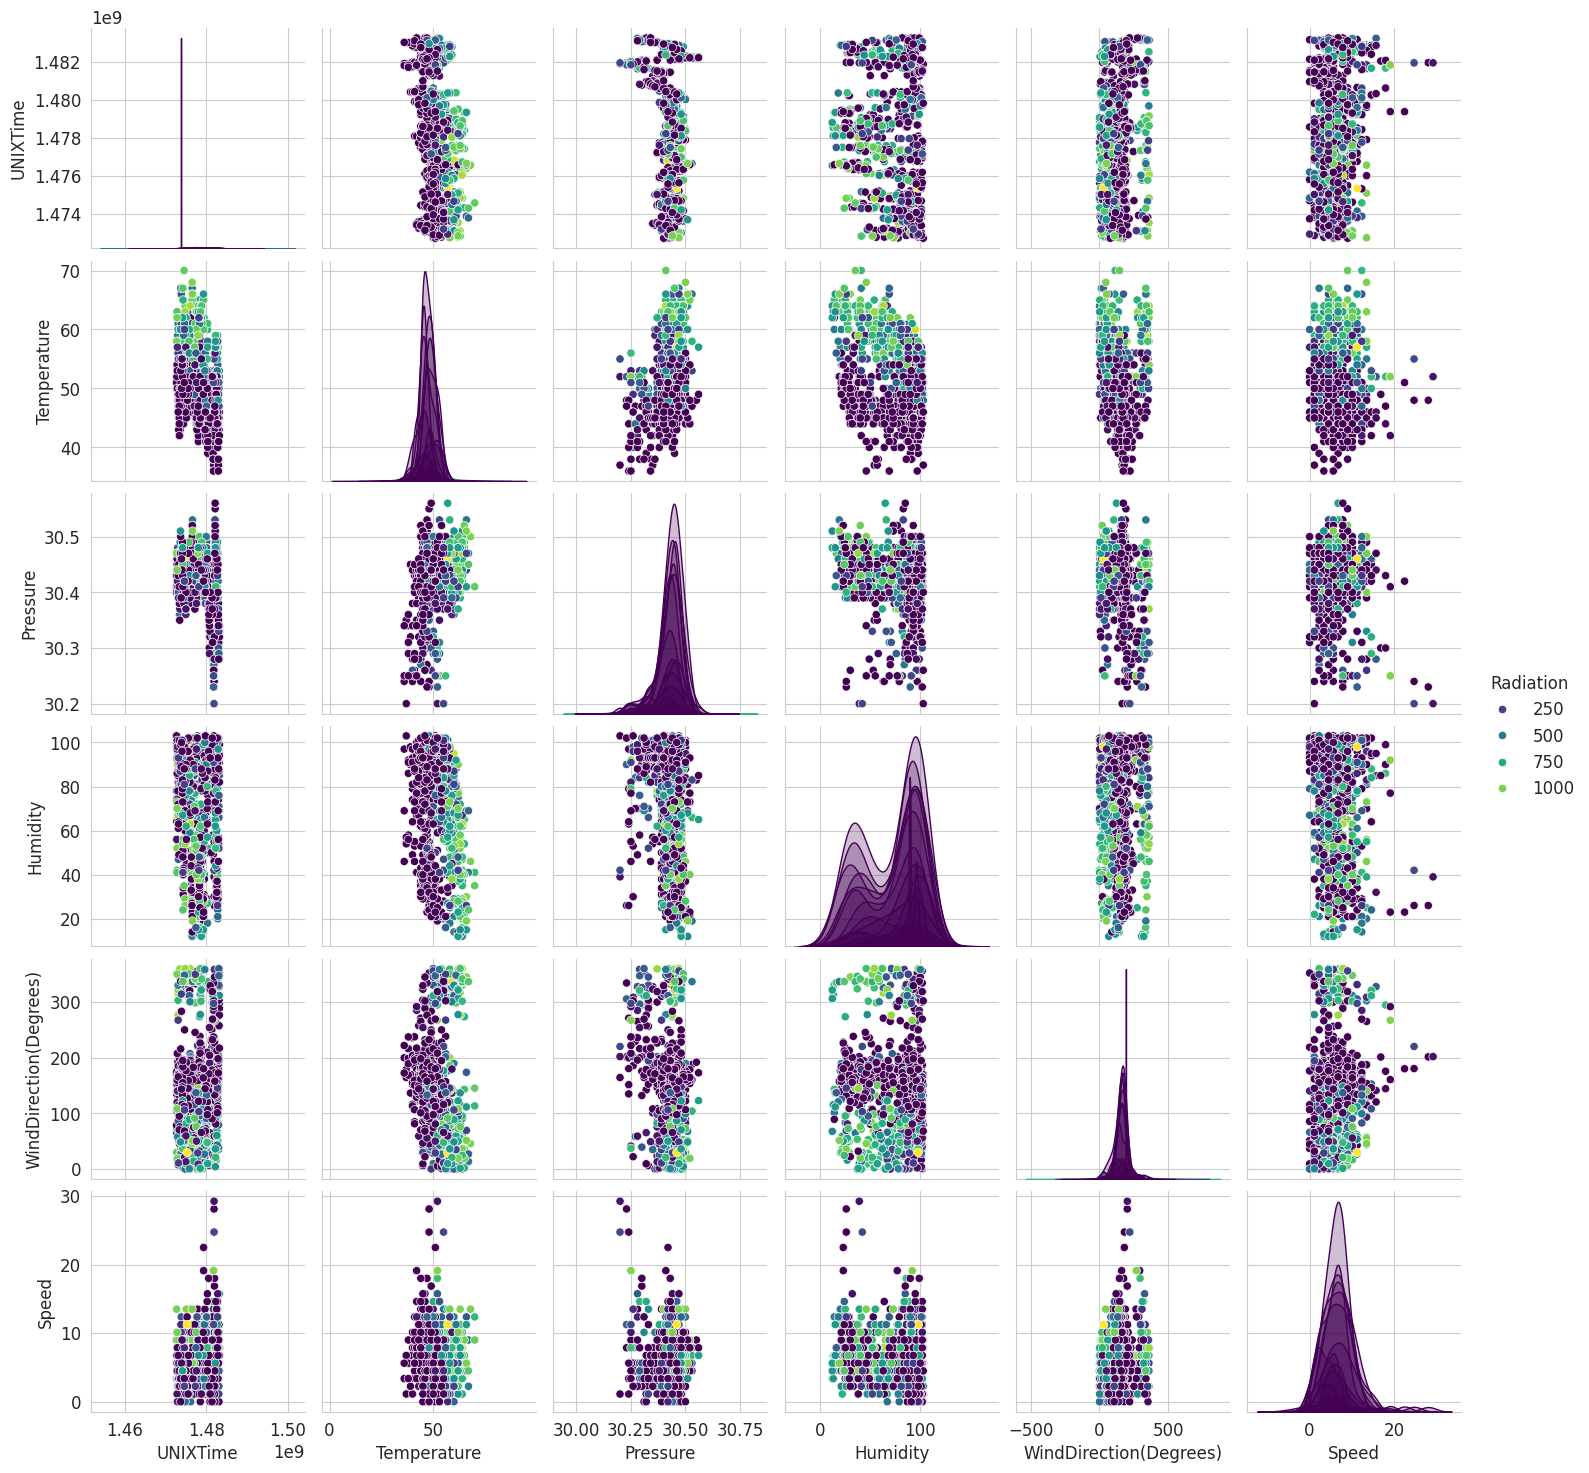

In [13]:
# Pairplots for the different features with Radiation as the hue
sns.set_style("whitegrid")
g = sns.pairplot(df.sample(n=1000), hue='Radiation', palette='viridis', diag_kind="kde", dropna=True)
plt.show()

### <p style="text-align:center;"><i>Figure 4: Pairplots for the various features with radiation as the hue</i></p>

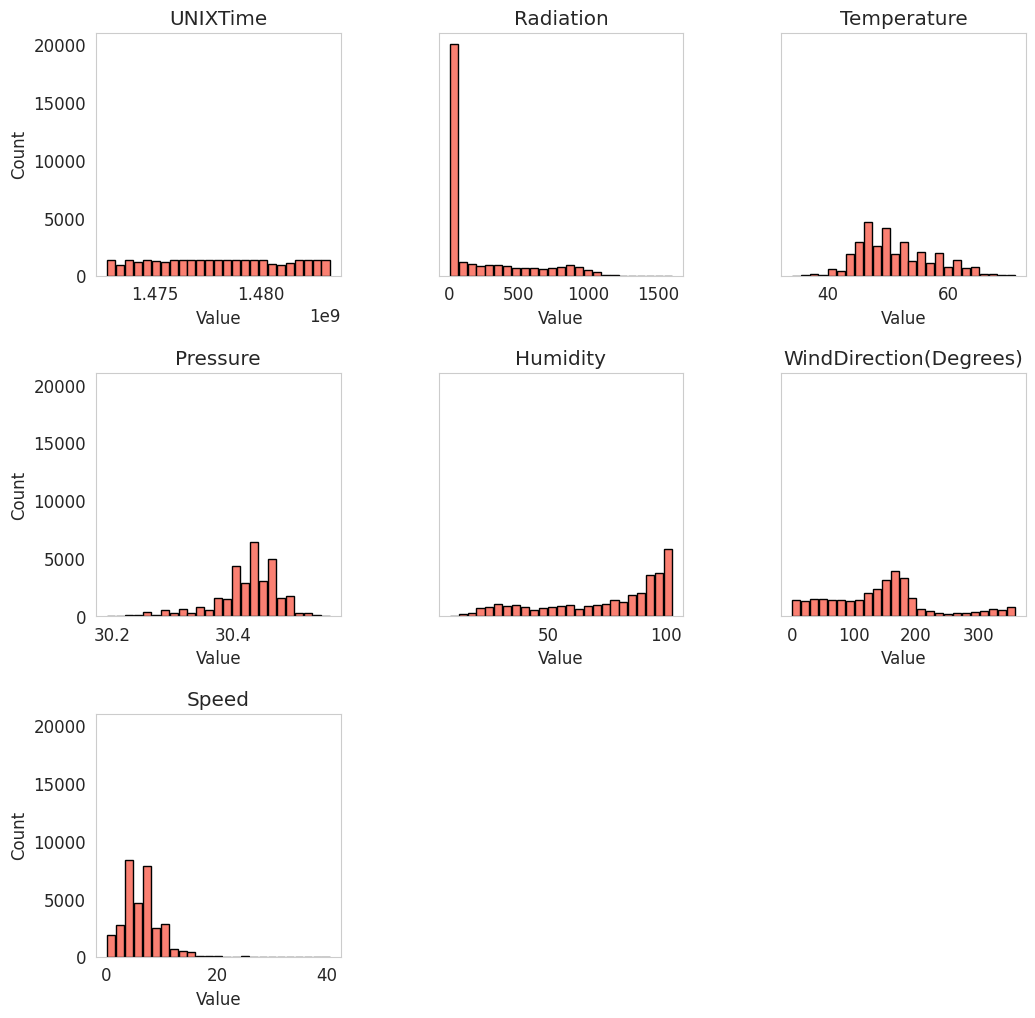

In [14]:
# Create a histogram of weight distribution counts for all samples
df_no_dates = df.drop(columns=['UNIXDateTime'])
ax = df_no_dates.hist(bins=25, grid=False, color='salmon', edgecolor='black', sharey=True, zorder=2, rwidth=0.9)
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Adjust values as needed
# Loop through the plots and add labels to x and y axes
for chart in ax.flatten():
    chart.set_xlabel("Value")
    chart.set_ylabel("Count")


### <p style="text-align:center;"><i>Figure 5: Looking at the histograms, there is a slight left skew for humidity, possibly due to the changing seasons. There is also an extreme right skew for the radiation data. I will have to deal with this as radiation is the target variable.</i></p>

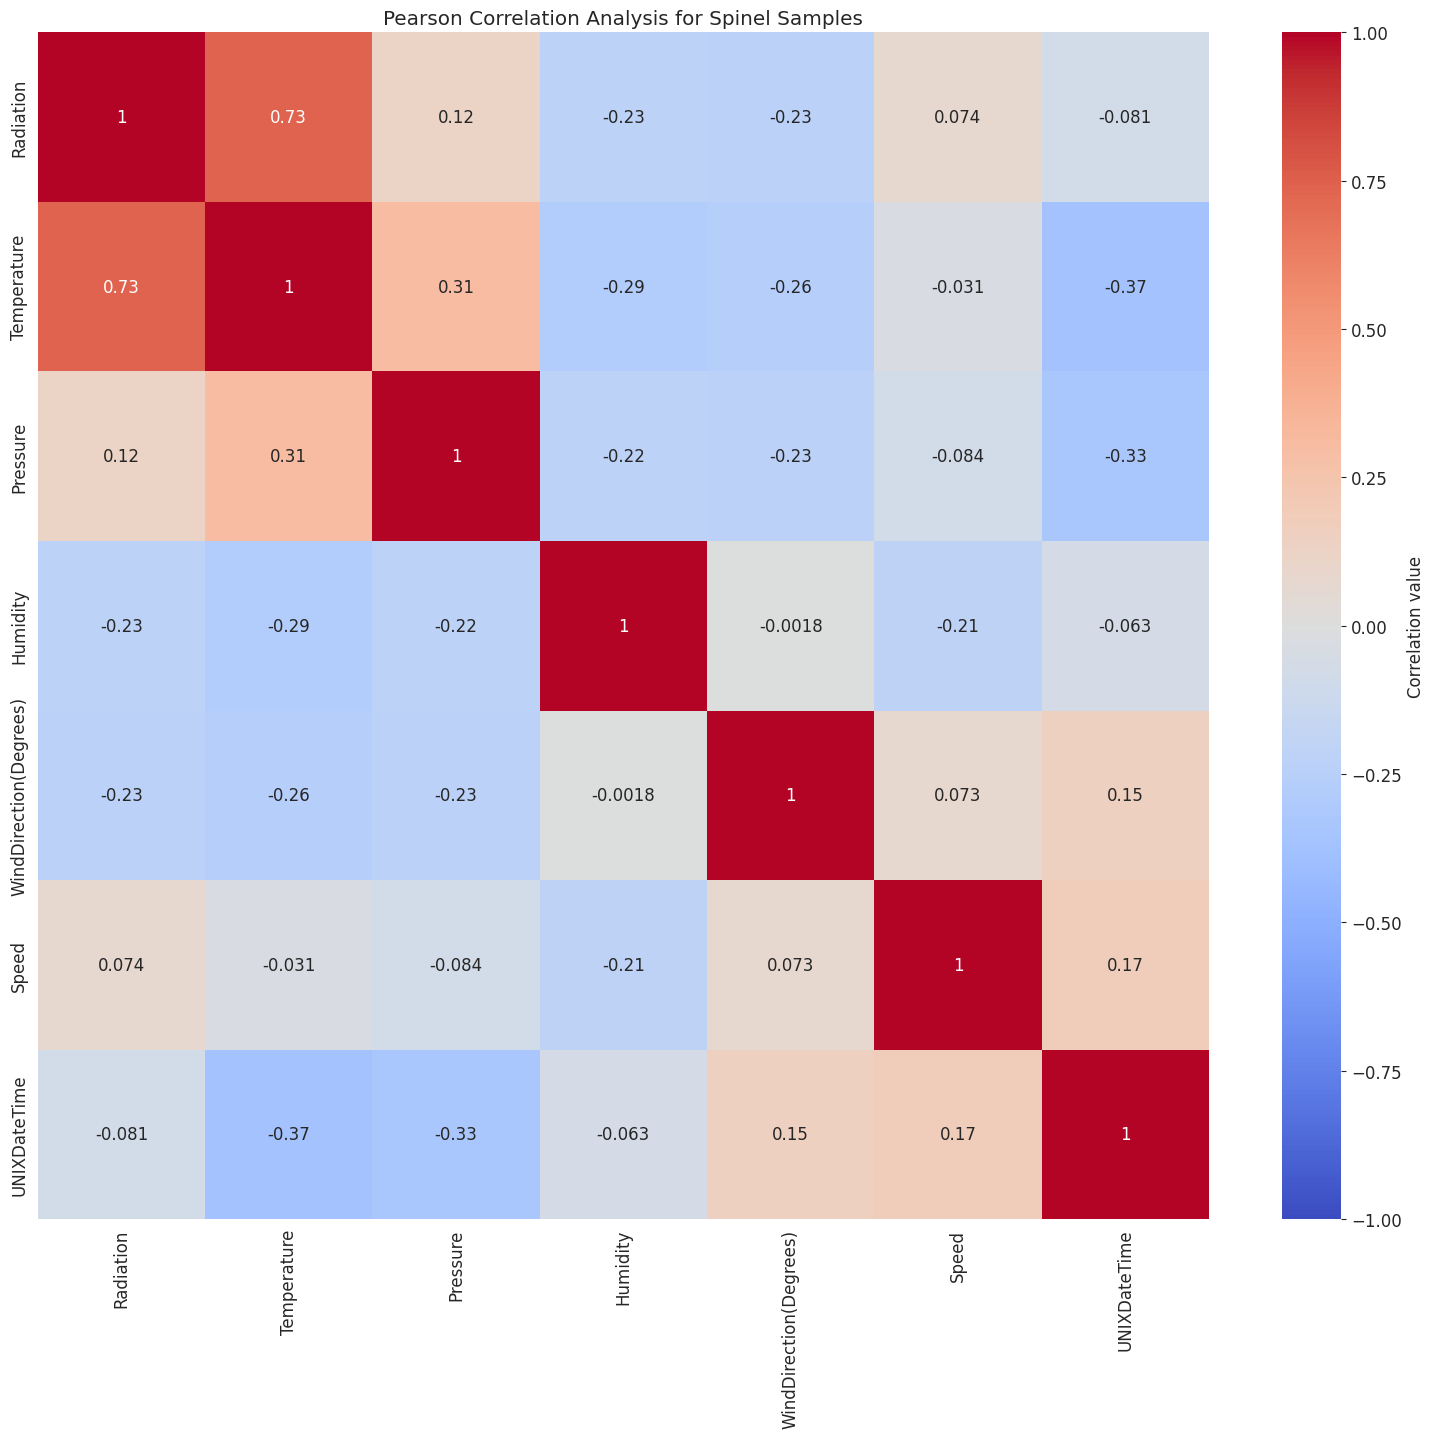

In [15]:
# Drop the Object columns
df_filtered = df.drop(columns=['UNIXTime', 'Data', 'Time', 'TimeSunRise', 'TimeSunSet'])

fig, ax = plt.subplots(figsize=[15, 15], sharex=True)

# Calculate the correlation matrix, dropping all NaN rows and columns
correlation_matrix = df_filtered.corr(method='pearson').dropna(axis=0, how='all').dropna(axis=1, how='all')

# Plot the results of the correlation as a heatmap
sns.heatmap(correlation_matrix, annot=True, vmin=-1, vmax=1, cmap='coolwarm', cbar_kws={'label': 'Correlation value'})
plt.title("Pearson Correlation Analysis for Spinel Samples")
ax.set_position([0.55, 0.1, 0.35, 0.8])  # Adjust position manually

plt.tight_layout()
plt.show()


### <p style="text-align:center;"><i>Figure 6: There appears to be a high correlation between radiation and temperature.</i></p>

## Preprocessing

---


The radiation values can be used directly. Instead of needing to encode values, I focused on properly splitting and standardizing the data. Because the target variable radiation is so heavily skewed, it would impact correct predictions. I tried a variety of methods to transform the data including Logarithmic Transformation(both natual log and log base 10), Square Root Transformation, Cube Root Transformation and Reciprocal Transformation. However, none of these methods really seemed to work. I also tried to apply power tansformers including the Box-Cox Transformation
and Yeo-Johnson Transformation to help stabilize variance and make the target variable more normally distributed. These attempts also failed. Nonetheless, utilizing the Quantile Transformer from Sci-Kit Learn did help to normalize my target variable.


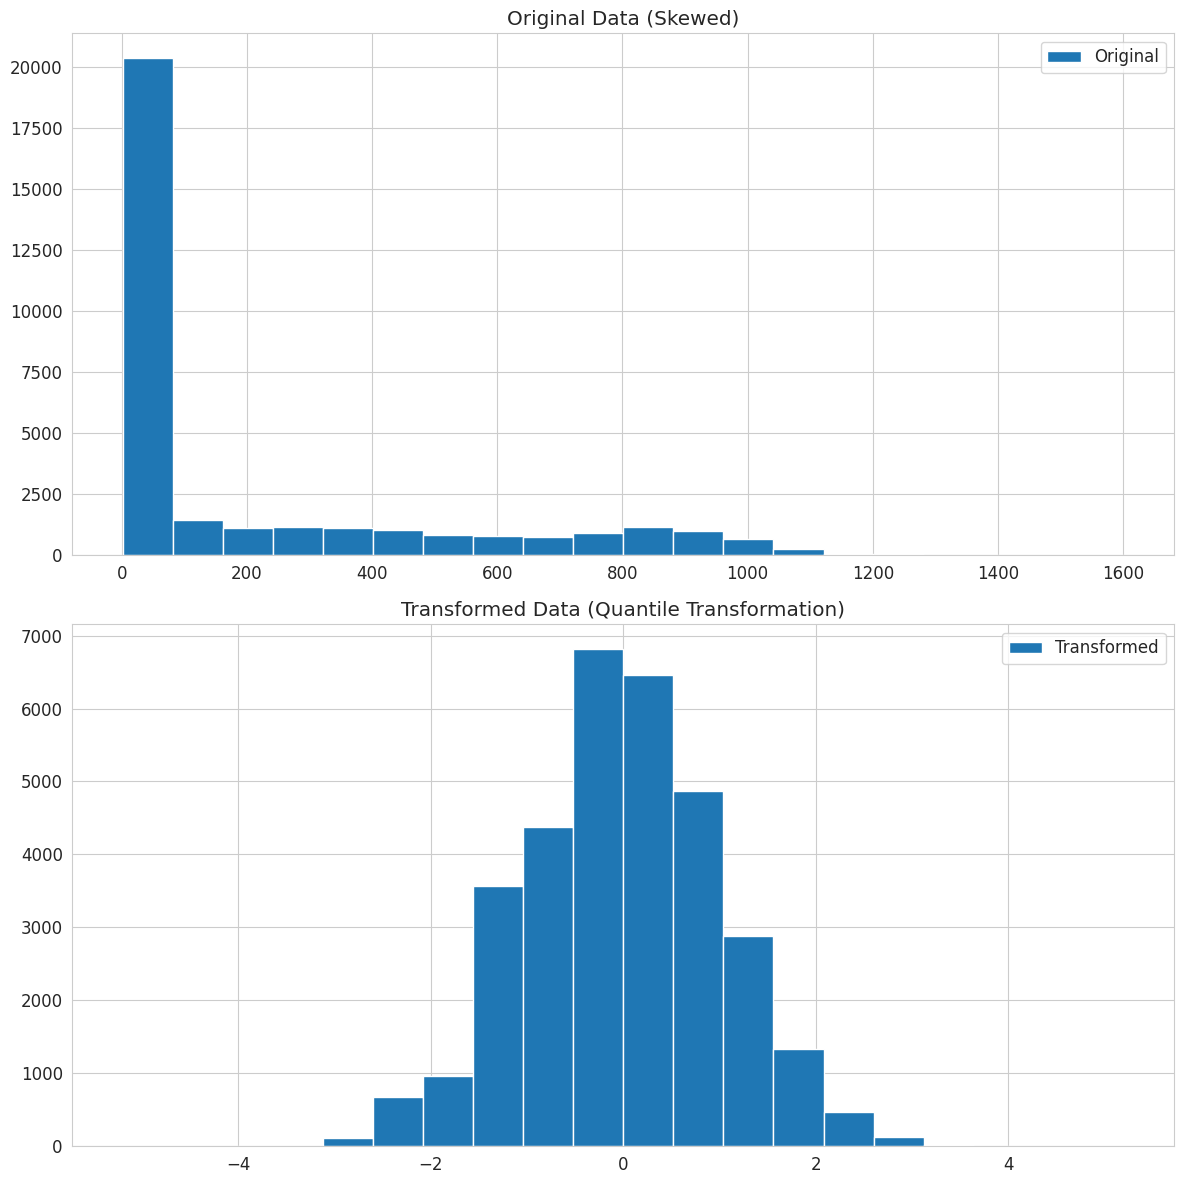

In [16]:
X_df = df_sorted.drop(['Data', 'Time', 'Radiation', 'TimeSunRise', 'TimeSunSet', 'UNIXDateTime', 'UNIXTime'], axis=1)
# Set the Feature Vectors
X = X_df.to_numpy()
# Set the target variables
y = df_sorted['Radiation']

# Visualize the original data
plt.subplot(2, 1, 1)
plt.hist(y, bins=20, label='Original')
plt.title('Original Data (Skewed)')
plt.legend()

# Apply Quantile Transformation
transformer = QuantileTransformer(output_distribution='normal', random_state=0) # or 'uniform'
df_transformed = transformer.fit_transform(y.values.reshape(-1, 1))

# Save the transformed target variable data
fitted_y = df_transformed.flatten()

# Visualize the transformed data
plt.subplot(2, 1, 2)
plt.hist(df_transformed, bins=20, label='Transformed')
plt.title('Transformed Data (Quantile Transformation)')
plt.legend()
plt.tight_layout()
plt.show()


### <p style="text-align:center;"><i>Figure 7: These plots show the original highly skewed data and then the transformed data using the Qunatile Transformer.</i></p>

## Splitting the Data


---


Because of the time series feature in the data that can be see in the EDA above, I performed a Time Series Split on the data.

In [18]:
# No stratified split of train, test and validation sets becuase the target is continous
X_train, X_test, y_train, y_test = train_test_split(X, fitted_y, test_size=0.2, random_state=42)

# Create TimeSeriesSplit object
test_size_int = int(0.2 * len(X)) # Calculate 20% of the dataset size
time_splitter = TimeSeriesSplit(n_splits=3, test_size=test_size_int)

# Perform stratified splitting
for train_index, test_index in time_splitter.split(X, fitted_y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = fitted_y[train_index], fitted_y[test_index]

In [19]:
scaler_X = StandardScaler()

X_train_scale = scaler_X.fit_transform(X_train)
X_test_scale = scaler_X.transform(X_test)

## Feature importance analysis


---

I will use the Random Forest Regrssor algorithm to determine the feature importance for my data set. This plot makes sense as there is a high correlation between temperature and radiation in the Pearson Correlation Matrix.

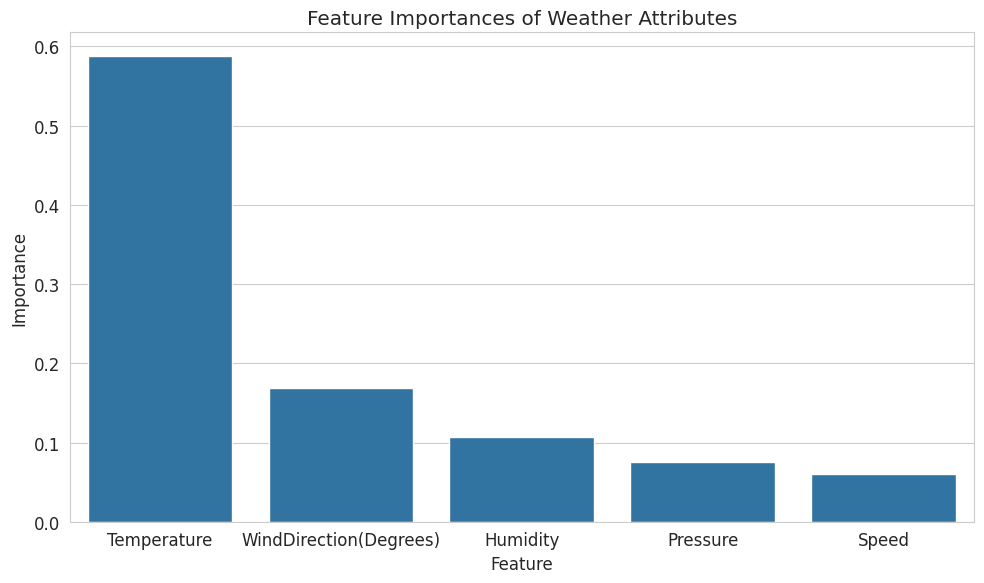

In [20]:
features = list(X_df.columns)
# Create a Random Forest Classifier model
rf_model = RandomForestRegressor(random_state=42)

# Train the model
rf_model.fit(X_train_scale, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
# Use feature_importances DataFrame instead of df
ax = sns.barplot(x='Feature', y='Importance', data=feature_importances)
plt.title('Feature Importances of Weather Attributes')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

### <p style="text-align:center;"><i>Figure 8: Feature importance using a Random Forest Regressor. As shown in the Pearson Correlation matrix, there is a high correlation between temperature and radiation. This temperature is an important input feature.</i></p>

## Multi-Model Comparison Setup

---
As I wished to compare the results of the 3 algorithms below, plus various other regression algorithms/models, I will create a Dataframe to hold those results


In [21]:
df_models = pd.DataFrame(data=None, columns=['Algorithm', 'r2_train', 'r2_test', 'mse_train', 'mse_test'])

## XGBoost Classifier

---


In [22]:
#This takes a long time to run, so it has been commented out
regressor=XGBRegressor(eval_metric='mse')
"""
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6, 7, 8],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.001, 0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train_scale, y_train)
print("The best hyperparameters are ",search.best_params_)"""

'\n# set up our search grid\nparam_grid = {"max_depth":    [4, 5, 6, 7, 8],\n              "n_estimators": [500, 600, 700],\n              "learning_rate": [0.001, 0.01, 0.015]}\n\n# try out every combination of the above values\nsearch = GridSearchCV(regressor, param_grid, cv=5).fit(X_train_scale, y_train)\nprint("The best hyperparameters are ",search.best_params_)'

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}

In [23]:
regressor=XGBRegressor(learning_rate = 0.01,
                       n_estimators  = 500,
                       max_depth     = 4,
                       eval_metric='mae',
                       objective="reg:squarederror",
                        )

regressor.fit(X_train_scale,
            y_train,
            verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
#Making predictions on the test set and train sets for comparison
y_pred_train = regressor.predict(X_train_scale)
y_pred_test = regressor.predict(X_test_scale)
# Calculate the mean squared error and R-squared score
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
## Add results to the Dataframe dictionary
df_models.loc[len(df_models.index)] = ['XGBoost', r2_train, r2_test, mse_train, mse_test]

print("Mean Squared Error:", mse_test)
print("R-squared Score:", r2_test)

Mean Squared Error: 0.40622871338965744
R-squared Score: 0.48124704777309035


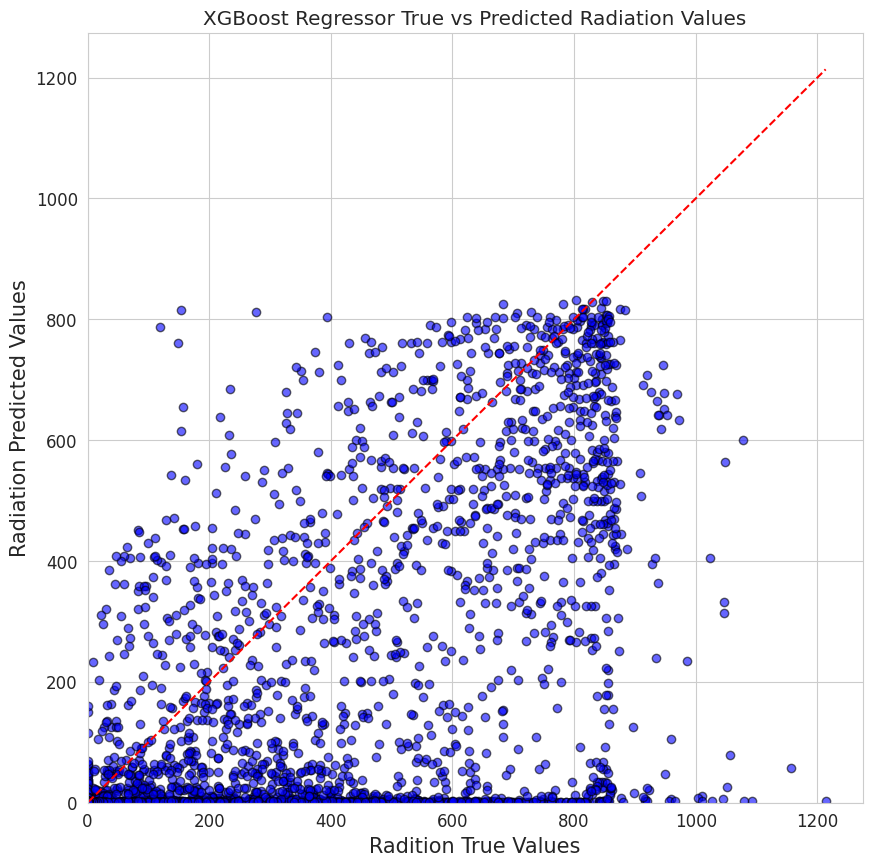

In [25]:
predicted_values = transformer.inverse_transform(y_pred_test.reshape(-1, 1))
true_value = transformer.inverse_transform(y_test.reshape(-1, 1))


plt.figure(figsize=(10, 10))
plt.scatter(true_value, predicted_values, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(true_value), max(true_value)], [min(true_value), max(true_value)], linestyle="--", color="red")
plt.xlabel('Radition True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.xlim(0)
plt.ylim(0)
plt.title("XGBoost Regressor True vs Predicted Radiation Values")

plt.show()

### <p style="text-align:center;"><i>Figure 9: True values vs predicted values using the XGBoost Regressor.</i></p>

In [26]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(regressor, X_train_scale, y_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.abs(scores)
print('Mean MSE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MSE: 0.375 (0.011)


## SVR

---
For the SVR I tried some random hyperparameters.


In [27]:
%%time
# This model takes some time to train
# Train SVR model
svr_rbf = SVR(kernel='linear', gamma=0.1, epsilon=.1)
svr_rbf.fit(X_train_scale, y_train)

CPU times: user 39.8 s, sys: 151 ms, total: 40 s
Wall time: 39.8 s


SVR(gamma=0.1, kernel='linear')

In [28]:
# Evaluate the model
y_pred_train = svr_rbf.predict(X_train_scale)
y_pred_test = svr_rbf.predict(X_test_scale)

In [29]:
# Calculate the mean squared error and R-squared score
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
## Add results to the Dataframe dictionary
df_models.loc[len(df_models.index)] = ['SVR', r2_train, r2_test, mse_train, mse_test]

print("Mean Squared Error:", mse_test)
print("R-squared Score:", r2_test)

Mean Squared Error: 0.42321559660851976
R-squared Score: 0.4595548445179599


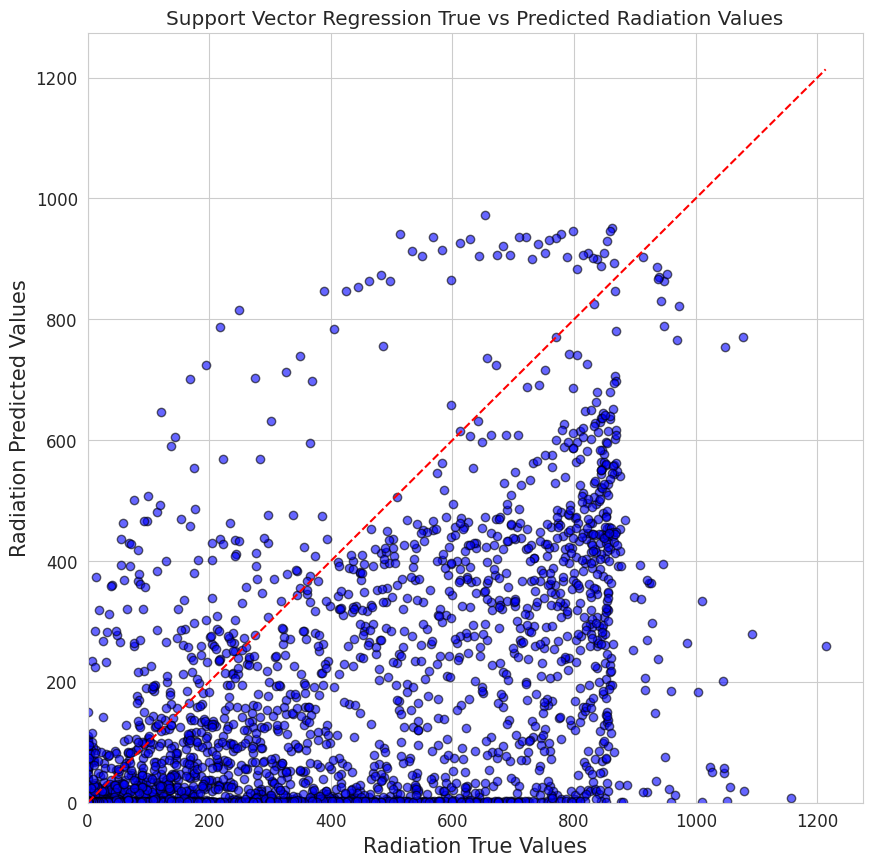

In [30]:
predicted_values = transformer.inverse_transform(y_pred_test.reshape(-1, 1))
true_value = transformer.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 10))
plt.scatter(true_value, predicted_values, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(true_value), max(true_value)], [min(true_value), max(true_value)], linestyle="--", color="red")
plt.xlabel('Radiation True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.title("Support Vector Regression True vs Predicted Radiation Values")
plt.xlim(0)
plt.ylim(0)

plt.show()

### <p style="text-align:center;"><i>Figure 10: True values vs predicted values using the Support Vector Regressor.</i></p>

## Linear Regression


---

Just used vanilla Linear Regression here without any hyperparmeter tuning. I may try to apply tuning for the final notebook to see if I can get better performance.

In [31]:
model = LinearRegression()

In [32]:
model.fit(X_train_scale, y_train)

LinearRegression()

In [33]:
# Evaluate the model
y_pred_train = svr_rbf.predict(X_train_scale)
y_pred_test = svr_rbf.predict(X_test_scale)

In [34]:
# Calculate the mean squared error and R-squared score
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
## Add results to the Dataframe dictionary
df_models.loc[len(df_models.index)] = ['LinearRegression', r2_train, r2_test, mse_train, mse_test]

print("Mean Squared Error:", mse_test)
print("R-squared Score:", r2_test)

Mean Squared Error: 0.42321559660851976
R-squared Score: 0.4595548445179599


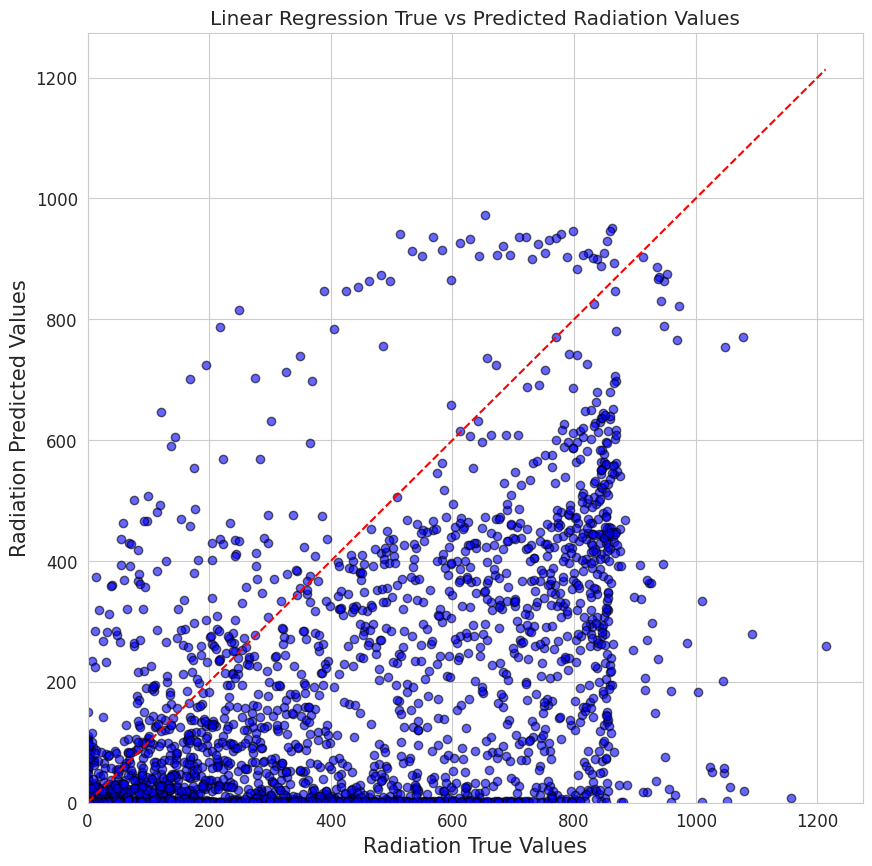

In [35]:
predicted_values = transformer.inverse_transform(y_pred_test.reshape(-1, 1))
true_value = transformer.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(10, 10))
plt.scatter(true_value, predicted_values, alpha=0.6, color="blue", edgecolors="k")
plt.plot([min(true_value), max(true_value)], [min(true_value), max(true_value)], linestyle="--", color="red")
plt.xlabel('Radiation True Values', fontsize=15)
plt.ylabel('Radiation Predicted Values', fontsize=15)
plt.title("Linear Regression True vs Predicted Radiation Values")
plt.xlim(0)
plt.ylim(0)

plt.show()

### <p style="text-align:center;"><i>Figure 11: True values vs predicted values using Linear Regression.</i></p>

## Multiple Model Comparison

---

I wanted to compare the R-Squares and MSE score for the 3 algorithms I looked at above to various other regression algorithms, to compare performance over a wide variety of different supervised regression techiques.

In [36]:
def make_model(X_tr, X_te, y_tr, y_te, model, model_name: str):
    model.fit(X_tr, y_tr)
    y_pred_train = model.predict(X_tr)
    y_pred_test = model.predict(X_te)
    r2_train = r2_score(y_tr, y_pred_train)
    mse_train = mean_squared_error(y_tr, y_pred_train)
    r2_test = r2_score(y_te, y_pred_test)
    mse_test = mean_squared_error(y_te, y_pred_test)
    df_models.loc[len(df_models.index)] = [model_name, r2_train, r2_test, mse_train, mse_test]


make_model(X_train_scale, X_test_scale, y_train, y_test, Ridge(), 'Ridge')
make_model(X_train_scale, X_test_scale, y_train, y_test, Lasso(), 'Lasso')
make_model(X_train_scale, X_test_scale, y_train, y_test, ElasticNet(), 'ElasticNet')
make_model(X_train_scale, X_test_scale, y_train, y_test, GradientBoostingRegressor(), 'GradientBoosting')
make_model(X_train_scale, X_test_scale, y_train, y_test, RandomForestRegressor(), 'RandomForest')

In [37]:
fig = go.Figure(data=[
    go.Bar(name='r2_train', x=df_models.Algorithm, y=df_models.r2_train),
    go.Bar(name='r2_test', x=df_models.Algorithm, y=df_models.r2_test)
])
fig.update_layout(template='plotly_dark', title='R2 for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 12: R-Square comparison of several different models for train and test predictions.</i></p>

In [38]:
fig = go.Figure(data=[
    go.Bar(name='mse_train', x=df_models.Algorithm, y=df_models.mse_train),
    go.Bar(name='mse_test', x=df_models.Algorithm, y=df_models.mse_test)
])
fig.update_layout(template='plotly_dark', title='MSE for Train and Test Sets for Various Regression Algorithms', title_x=0.5)

### <p style="text-align:center;"><i>Figure 13: MSE comparison of several different models for train and test predictions.</i></p>

## Conclusion

---

Looking at the R-squared values, the XGBoost Regressor seems to perform slightly better than others on the test data, although random forest performs best on the training data. In the final notbook I might look at some ways to further improve these scores includin trying to determine what other pre-processing steps are necessay to increase the R-squared score and decrease MSE. I could try feature engineering, binning or possibly another scaler on my features.

## Questions

---

1. **Which method did you like the most?**
I wasn't partial to any of the algorithms I used because none of them really did well on the data. I suppose if I had to choose one, I like XGBoost because I feel like it is a powerful algorithm, despite hyperparameter tuning not providing great results.
1. **Which method did you like the least?**
In my last step I ran the data through several algorithms and Lasso did the worst according to the R-squared and MSE scores, so this would be the method I liked the least based off performance with no hyperparameter tuning.
1. **How did you score these supervised models?**
I scored the models using R-squared and MSE.
1. **Did the output align with your geologic understanding?**
The target variable for this assignment was heavily right-skewed, which I believe majorly impacted the models. It fits with my geological understanding, because radiation levels on Earth, even where the data was collected, would remain relatively low due to the electromagnetic field that protects Earth, although solar flares and solar storms may cause sudden bursts of high radiation, which is shown in the data.
1. **What did you want to learn more about?**
I want to determine a better way to deal with the skewed target values, as I believe it was and still is majorly impacting performance. I attempted a variety of different transformations to fix the issue, but the Quantile Transform somewhat fixed the issue. I tried applying both the normal and uniform output distribution parameter for that transform and seemed to get better performance with the uniform output distribution. Nonetheless, I think there might be more I could do from a preprocessing standpoint to improve model performance. I was thinking about binning as part of feature engineering to improve the performance of the models possibly.
1. **Did you pre-process your data?**
Yes, as described in the previous question, I applied a transformation to radiation, which was my target variable. I sorted the data by time, then dropped the time and date columns as they were not needed. I applied a Standard Scaler to all of my feature vectors. I also used the TimeSeriesSplit object to split my data after I sorted it, because I was concerned that there might be some autocorrelation due to the fact that the data was collected over 4 months. I might consider another way of splitting for the final assignment.
1. **Do all models require pre-processing?**
Yes, all the models require pre-processing due to the skewed target and the temporal component of the data.
